In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from skyfield.api import load
from skyfield import almanac
import seaborn as sns

In [2]:
accidents = pd.read_csv("../PrometneNesreče.csv")
#print(len(accidents))

C:\Users\Hana\AppData\Local\Temp\ipykernel_2628\233486747.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("../PrometneNesreče.csv")


In [3]:
accidents['NastanekDatumCas'] = pd.to_datetime(accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
print(f"NastanekDatumCas column dtype: {accidents['NastanekDatumCas'].dtype}")

accidents['date'] = accidents['NastanekDatumCas'].dt.date
accidents['date'] = pd.to_datetime(accidents['date'], format='ISO8601', errors='coerce')
print(f"date column dtype: {accidents['date'].dtype}")

NastanekDatumCas column dtype: datetime64[ns]
date column dtype: datetime64[ns]


#### Dodajanje stolpcev

In [4]:
day_translation = {
    'Monday': 'Ponedeljek',
    'Tuesday': 'Torek',
    'Wednesday': 'Sreda',
    'Thursday': 'Četrtek',
    'Friday': 'Petek',
    'Saturday': 'Sobota',
    'Sunday': 'Nedelja'
}
day_order_slo = ['Ponedeljek', 'Torek', 'Sreda', 'Četrtek', 'Petek', 'Sobota', 'Nedelja']

month_translation = {
    'January': 'Januar', 'February': 'Februar', 'March': 'Marec',
    'April': 'April', 'May': 'Maj', 'June': 'Junij',
    'July': 'Julij', 'August': 'Avgust', 'September': 'September',
    'October': 'Oktober', 'November': 'November', 'December': 'December'
}
month_order_slo = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']

accidents['Day_EN'] = accidents['NastanekDatumCas'].dt.day_name()
accidents['Day_SLO'] = accidents['Day_EN'].map(day_translation)

accidents['Mesec_EN'] = accidents['NastanekDatumCas'].dt.month_name()
accidents['Mesec_SLO'] = accidents['Mesec_EN'].map(month_translation)

accidents['Datum'] = accidents['NastanekDatumCas'].dt.date
accidents['Ura'] = accidents['NastanekDatumCas'].dt.hour

accidents['Teden'] = accidents['NastanekDatumCas'].dt.to_period('W').apply(lambda r: r.start_time)

accidents['Leto'] = accidents['NastanekDatumCas'].dt.year

# Severity
conditions = [
    (accidents['LjudjePoskodovani'] == 0) & (accidents['LjudjeMrtvi'] == 0),
    (accidents['LjudjePoskodovani'] != 0) & (accidents['LjudjeMrtvi'] == 0),
    (accidents['LjudjeMrtvi'] != 0)
]

# Določi oznake
severity_labels = ['no_injury', 'injury', 'death']

# Dodaj stolpec za severity
accidents['Severity'] = np.select(conditions, severity_labels, default='unknown')
# display(accidents)

# Analiza prometnih nesreč glede na lunine mene

Za pridobitev podatkov o luninih menah bom uporabila knjižnico Skyfield, ki naloži `de421.bsp` efemeride, ki jih vzdržuje NASA JPL (Jet Propulsion Laboratory).

In [5]:
ts = load.timescale()  # Ustvarjanje time scale objekta
eph = load('de421.bsp')  # Nalaganje efemerid

start = ts.utc(2009, 12, 29)
end = ts.utc(2024, 1, 3)
t, y = almanac.find_discrete(start, end, almanac.moon_phases(eph))  # funkcija najde čase (t) med 'start' in 'end, ko je luna spremenila fazo.
                                                                    # y je tabela int-ov med 0 in 3.
                                                                        # 0 = New Moon (prazna luna)
                                                                        # 1 = First Quarter (prvi krajec)
                                                                        # 2 = Full Moon (polna luna)
                                                                        # 3 = Last Quarter (zadnji krajec)

# print(t.utc_iso())
# print(y)
# print([almanac.MOON_PHASES[yi] for yi in y])

In [6]:
# Ustvarjanje dataframe-a
moon_df = pd.DataFrame({
    'phase_time': t.utc_datetime(),
    'moon_phase': [almanac.MOON_PHASES[yi] for yi in y]  # Pretvori številke v imena luninih men.
})

# display(moon_df)

# Pretvorimo 'phase_time' v pravilen podatkovni tip in pretvorimo v pravilen časovni pas
moon_df['phase_time'] = pd.to_datetime(moon_df['phase_time'], format='ISO8601', utc=True, errors='coerce')
moon_df['phase_time'] = moon_df['phase_time'].dt.tz_convert('Europe/Ljubljana')

# Izluščimo samo datum
moon_df['date'] = moon_df['phase_time'].dt.date
moon_df['date'] = pd.to_datetime(moon_df['date'], format='ISO8601', errors='coerce')

# display(moon_df)
# moon_df.to_csv("../lunine_mene_2010_2023.csv", index=False)

In [7]:
print(f"phase_time column dtype: {moon_df['phase_time'].dtype}")
print(f"date column dtype: {moon_df['date'].dtype}")

# print(moon_df.head())

phase_time column dtype: datetime64[ns, Europe/Ljubljana]
date column dtype: datetime64[ns]


In [19]:
lunine_mene = ['Prazna luna', 'Prvi krajec', 'Polna luna', 'Zadnji krajec', 'Ostalo']
eng_lunine_mene = ['New Moon', 'First Quarter', 'Full Moon', 'Last Quarter', 'None']

moon_phase_translation = {
    'New Moon': 'Prazna luna',
    'First Quarter': 'Prvi krajec',
    'Full Moon': 'Polna luna',
    'Last Quarter': 'Zadnji krajec',
    'None': 'Ostalo',
}

Upoštevala bom nesreče, ki so se zgodile na dan lunine mene in nesreče, ki so se zgodile en dan prej ali en dan kasneje.

In [38]:
# Za vsako lunino meno shranim tudi dan prej in dan kasneje
expanded_moon_df = pd.concat([
    moon_df.assign(date=moon_df['date'] - timedelta(days=1)),
    moon_df.assign(date=moon_df['date']),
    moon_df.assign(date=moon_df['date'] + timedelta(days=1))
])

# print(expanded_moon_df.head())

# Združitev podatkov o nesrečah s podatki o luninih menah
accidents_moon = accidents.merge(expanded_moon_df, on='date', how='left')

# Če ima vrstica vrednost Nan, jo spremenim v None.
accidents_moon['moon_phase'] = accidents_moon['moon_phase'].fillna('None')

# Prevedem imena luninih men
accidents_moon['moon_phase_SLO'] = accidents_moon['moon_phase'].map(moon_phase_translation)

accidents_moon.to_csv("../nesrece_lunine_mene_2010_2023.csv", index=False)

# print(accidents_moon.columns)
display(accidents_moon)

,NastanekDatumCas,WGSLat,WGSLon,Leto,Obcina,VrstaDogodka,SkupinaDogodka,Dogodek,CORSBesedilo,Opis poteka intervencije,...,Day_SLO,Mesec_EN,Mesec_SLO,Datum,Ura,Teden,Severity,phase_time,moon_phase,moon_phase_SLO
0,2010-01-01 04:59:00,46.007562,15.304263,2010,SEVNICA,NESREČE V PROMETU,Nesreče v cestnem prometu,prometne nesreče,Ob 4.59 je v Sevnici zagorelo osebno vozilo. P...,B.P.; Po prihodu na prometno nesrečo smo začel...,...,Petek,January,Januar,2010-01-01,4,2009-12-28,no_injury,2009-12-31 20:12:44.992327+01:00,Full Moon,Polna luna
1,2010-01-01 07:41:00,45.546550,13.729435,2010,KOPER,NESREČE V PROMETU,Nesreče v cestnem prometu,prometne nesreče,Ob 7.41 je voznik z osebnim vozilom zapeljal s...,Vozilo s potniki je zdrsnilo izven vozišča. U...,...,Petek,January,Januar,2010-01-01,7,2009-12-28,no_injury,2009-12-31 20:12:44.992327+01:00,Full Moon,Polna luna
2,2010-01-01 16:15:00,46.383287,15.524107,2010,SLOVENSKA BISTRICA,NESREČE V PROMETU,Nesreče v cestnem prometu,prometne nesreče,Ob 16.15 so posredovali gasilci PGD Slovenska ...,"PO PRIHODU NA KRAJ SMO SLEDNJEGA ZAVAROVALI,PO...",...,Petek,January,Januar,2010-01-01,16,2009-12-28,no_injury,2009-12-31 20:12:44.992327+01:00,Full Moon,Polna luna
3,2010-01-02 11:14:00,46.231985,14.616350,2010,KAMNIK,NESREČE V PROMETU,Nesreče v cestnem prometu,prometne nesreče,Ob 11.14 je zapeljalo osebno vozil s cestišča ...,Gasilci PGD Kamnik so prevrnjeno vozilo s tehn...,...,Sobota,January,Januar,2010-01-02,11,2009-12-28,no_injury,NaT,None,Ostalo
4,2010-01-02 13:12:00,46.236737,15.124345,2010,PREBOLD,NESREČE V PROMETU,Nesreče v cestnem prometu,prometne nesreče,Ob 13.15 so gasilci PGE Celje odšla na pomoč v...,Osebno vozilo je zapeljalo iz makadamske ceste...,...,Sobota,January,Januar,2010-01-02,13,2009-12-28,no_injury,NaT,None,Ostalo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33594,2023-12-31 14:20:33,46.318542,13.980634,2023,BOHINJ,NESREČE V PROMETU,Nesreče v cestnem prometu,prometne nesreče,"Ob 14:20 je na cesti Koprivnik–Goreljek, občin...","Ob 14:20 je na cesti Koprivnik - Goreljek, o...",...,Nedelja,December,December,2023-12-31,14,2023-12-25,no_injury,NaT,None,Ostalo
33595,2023-12-31 14:52:13,46.704488,16.131454,2023,PUCONCI,NESREČE V PROMETU,Nesreče v cestnem prometu,prometne nesreče,"Ob 14.54 je na cesti Gorica–Brezovci, občina P...","Ob 14:54 smo bili obveščeni s strani Reca Ms, ...",...,Nedelja,December,December,2023-12-31,14,2023-12-25,injury,NaT,None,Ostalo
33596,2023-12-31 20:56:32,46.276658,15.179021,2023,ŽALEC,NESREČE V PROMETU,Nesreče v cestnem prometu,prometne nesreče,Ob 20.56 je v naselju Velika Pirešica v občini...,Gasilci PGE Celje smo ob prihodu na kraj izved...,...,Nedelja,December,December,2023-12-31,20,2023-12-25,no_injury,NaT,None,Ostalo
33597,2023-12-31 21:12:55,46.285601,15.204133,2023,ŽALEC,NESREČE V PROMETU,Nesreče v cestnem prometu,prometne nesreče,"Ob 21.12 je v naselju Galicija, občina Žalec, ...",Gasilci PGE Celje smo ob prihodu na kraj izved...,...,Nedelja,December,December,2023-12-31,21,2023-12-25,no_injury,NaT,None,Ostalo


## Razporeditev nesreč glede na lunino meno

In [21]:
# Število dni za vsako lunino meno in dni brez lunine mene

# Dnevi brez lunine mene (torej dnevi, ki niso +/- 1 dan od dneva lunine mene)
start_date = datetime(2010, 1, 1)
end_date = datetime(2023, 12, 31)
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
no_phase_dates = all_dates.difference(expanded_moon_df['date'])
# print(f"Days with no moon phase: {len(no_phase_dates)}")

# Dnevi z lunino meno (torej dnevi, ki so +/- 1 dan od dneva lunine mene)
count_phase_days = expanded_moon_df['moon_phase'].value_counts()
count_phase_days = count_phase_days.reindex(eng_lunine_mene)
count_phase_days['None'] = len(no_phase_dates)
print(count_phase_days)

moon_phase
New Moon          519.0
First Quarter     519.0
Full Moon         522.0
Last Quarter      519.0
None             3036.0
Name: count, dtype: float64


In [22]:
# Število prometnih nesreč pri vsaki lunini meni
count_accidents = accidents_moon['moon_phase'].value_counts()

# Sortiranje po pravem vrstnem redu luninih men
count_accidents = count_accidents.reindex(eng_lunine_mene)
#print(count_accidents)

# Izračun povprečnega števila nesreč na dan glede na lunino meno
accidents_per_day = count_accidents / count_phase_days
print(accidents_per_day)

moon_phase
New Moon         6.593449
First Quarter    6.678227
Full Moon        6.423372
Last Quarter     6.558767
None             6.572464
Name: count, dtype: float64


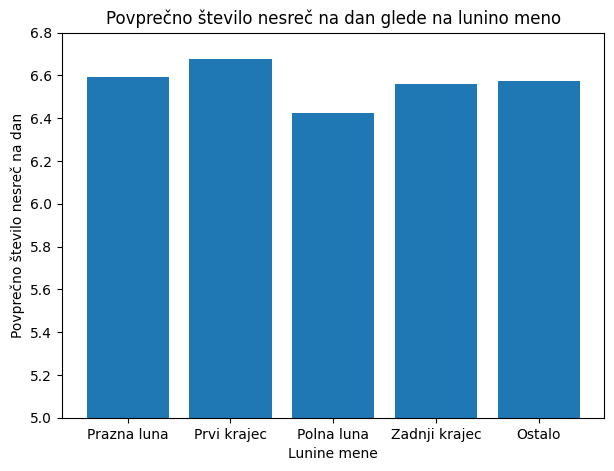

In [23]:
# Stolpčni diagram
plt.figure(figsize=(7, 5))
plt.bar(lunine_mene, accidents_per_day.values)

plt.xlabel('Lunine mene')
plt.ylabel('Povprečno število nesreč na dan')
plt.title('Povprečno število nesreč na dan glede na lunino meno')

plt.ylim(5, 6.8)    # Y-os JE SKALIRANA!!
plt.show()

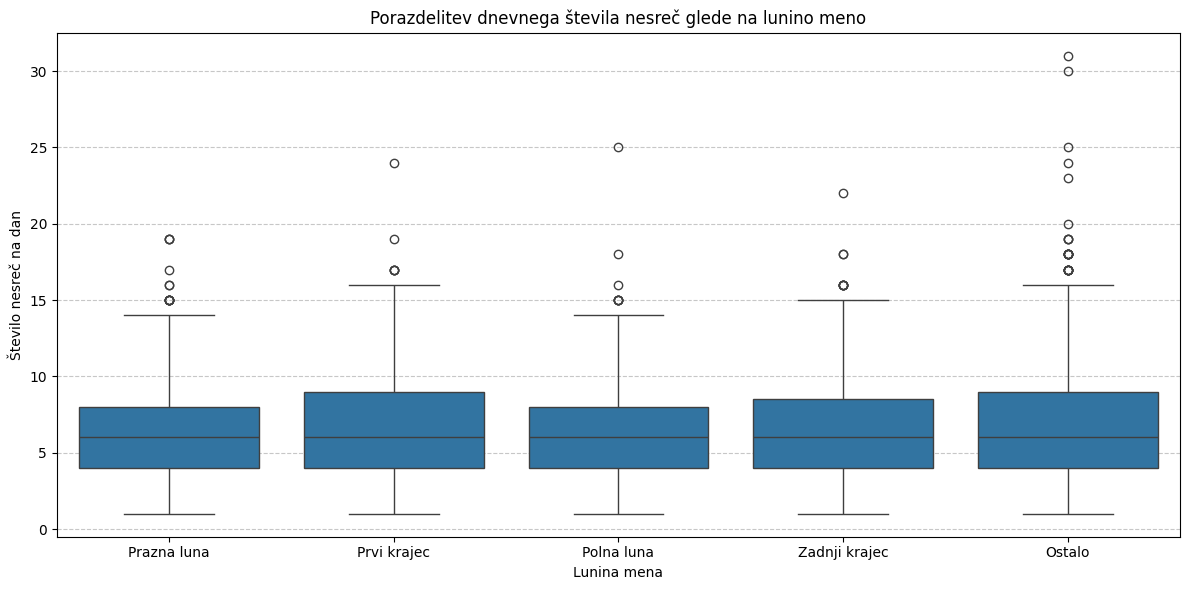

In [27]:
# BOXPLOT
# Najprej grupiram in preštejem nesreče
grouped = accidents_moon.groupby(['Datum', 'moon_phase_SLO']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='moon_phase_SLO', y='accident_count', order=lunine_mene)
plt.title('Porazdelitev dnevnega števila nesreč glede na lunino meno')
plt.xlabel('Lunina mena')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Resnost posledic prometnih nesreč glede na lunino meno**

Tri kategorije nesreč:
- **Nesreče brez poškodovancev**: udeleženci niso bili poškodovani in nihče ni umrl
- **Nesreče s poškodbami**: nekateri udeleženci so bili poškodovani, vendar nihče ni umrl
- **Nesreče s smrtnim izidom**: vsaj eden od udeležencev je umrl (v nesreči so bili lahko tudi drugi, ki so bili poškodovani, vendar take nesreče ne štejem v kategorijo "Nesreče s poškodbami")

In [13]:
mask_no_injury = ((accidents_moon['LjudjePoskodovani'] == 0) & (accidents_moon['LjudjeMrtvi'] == 0))
mask_injury = ((accidents_moon['LjudjePoskodovani'] != 0) & (accidents_moon['LjudjeMrtvi'] == 0))
mask_death = (accidents_moon['LjudjeMrtvi'] != 0)

acc_moon_no_injury = accidents_moon[mask_no_injury]
acc_moon_injury = accidents_moon[mask_injury]
acc_moon_death = accidents_moon[mask_death]

count_no_injury = acc_moon_no_injury['moon_phase'].value_counts()
count_injury = acc_moon_injury['moon_phase'].value_counts()
count_death = acc_moon_death['moon_phase'].value_counts()

count_no_injury = count_no_injury.reindex(eng_lunine_mene)
count_injury = count_injury.reindex(eng_lunine_mene)
count_death = count_death.reindex(eng_lunine_mene)

# count_no_injury = count_no_injury.drop('None')
# count_injury = count_injury.drop('None')
# count_death = count_death.drop('None')
# print(count_no_injury)

## Nesreče brez poškodovancev

moon_phase
New Moon          914
First Quarter     954
Full Moon         933
Last Quarter     1010
None             5632
Name: count, dtype: int64


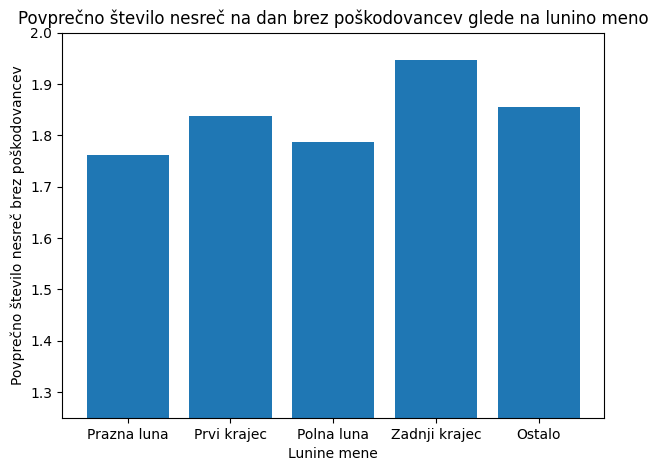

In [14]:
print(count_no_injury)

# Stolpčni diagram za nepovprečene vrednosti
#
# Stolpčni diagram
# plt.figure(figsize=(7, 5))
# plt.bar(lunine_mene[:-1], count_no_injury.values)

# plt.xlabel('Lunine mene')
# plt.ylabel('Število nesreč brez poškodovancev')
# plt.title('Število nesreč brez poškodovancev glede na lunino meno')

# plt.ylim(500, 1050)    # Y-os JE SKALIRANA!!
# plt.show()


# Povprečno število nesreč na dan brez poškodovancev glede na lunino meno
no_injury_per_day = count_no_injury / count_phase_days

# Stolpčni diagram
plt.figure(figsize=(7, 5))
plt.bar(lunine_mene, no_injury_per_day.values)

plt.xlabel('Lunine mene')
plt.ylabel('Povprečno število nesreč brez poškodovancev')
plt.title('Povprečno število nesreč na dan brez poškodovancev glede na lunino meno')

plt.ylim(1.25, 2)    # Y-os JE SKALIRANA!!
plt.show()

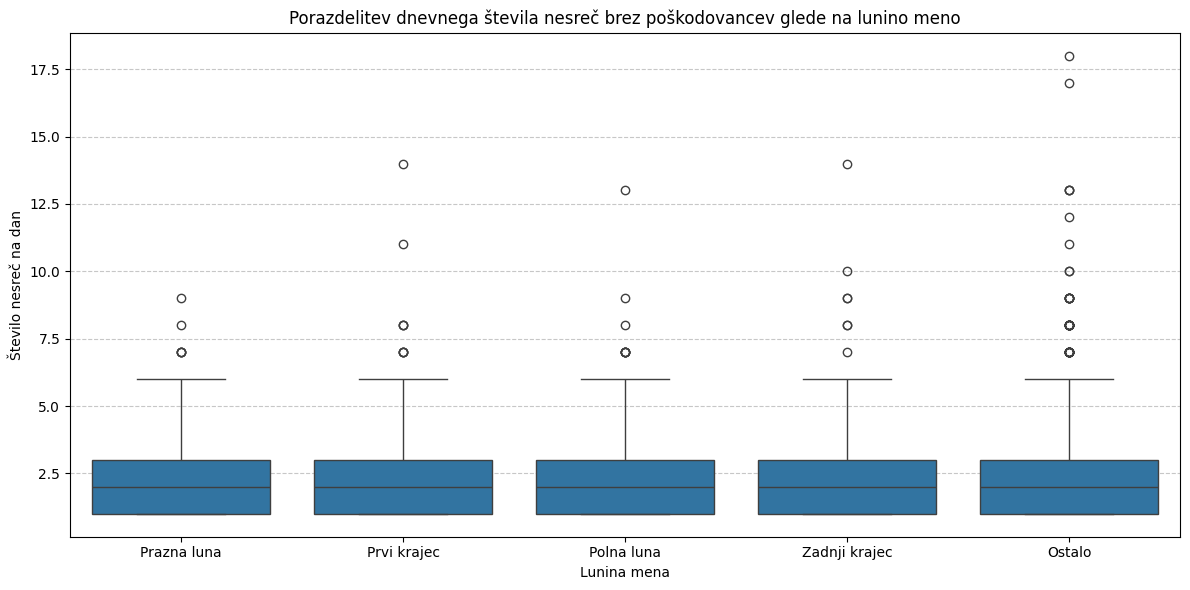

In [28]:
# BOXPLOT
mask_no_injury = (accidents_moon['Severity'] == 'no_injury')
df_no_injury = accidents_moon[mask_no_injury]

# Najprej grupiram in preštejem nesreče
grouped = df_no_injury.groupby(['Datum', 'moon_phase_SLO']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='moon_phase_SLO', y='accident_count', order=lunine_mene)
plt.title('Porazdelitev dnevnega števila nesreč brez poškodovancev glede na lunino meno')
plt.xlabel('Lunina mena')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Nesreče s poškodbami

moon_phase
New Moon          2386
First Quarter     2400
Full Moon         2293
Last Quarter      2261
None             13591
Name: count, dtype: int64


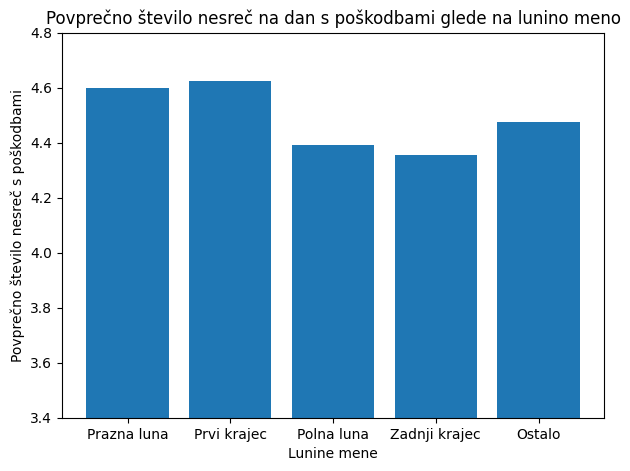

In [15]:
print(count_injury)

# Stolpčni diagram za nepovprečene vrednosti
#
# plt.figure(figsize=(7, 5))
# plt.bar(lunine_mene[:-1], count_injury.values)

# plt.xlabel('Lunine mene')
# plt.ylabel('Število nesreč brez poškodovancev')
# plt.title('Število nesreč brez poškodovancev glede na lunino meno')

# plt.ylim(1600, 2500)    # Y-os JE SKALIRANA!!
# plt.show()


# Povprečno število nesreč na dan brez poškodovancev glede na lunino meno
injury_per_day = count_injury / count_phase_days

# Stolpčni diagram
plt.figure(figsize=(7, 5))
plt.bar(lunine_mene, injury_per_day.values)

plt.xlabel('Lunine mene')
plt.ylabel('Povprečno število nesreč s poškodbami')
plt.title('Povprečno število nesreč na dan s poškodbami glede na lunino meno')

plt.ylim(3.4, 4.8)    # Y-os JE SKALIRANA!!
plt.show()

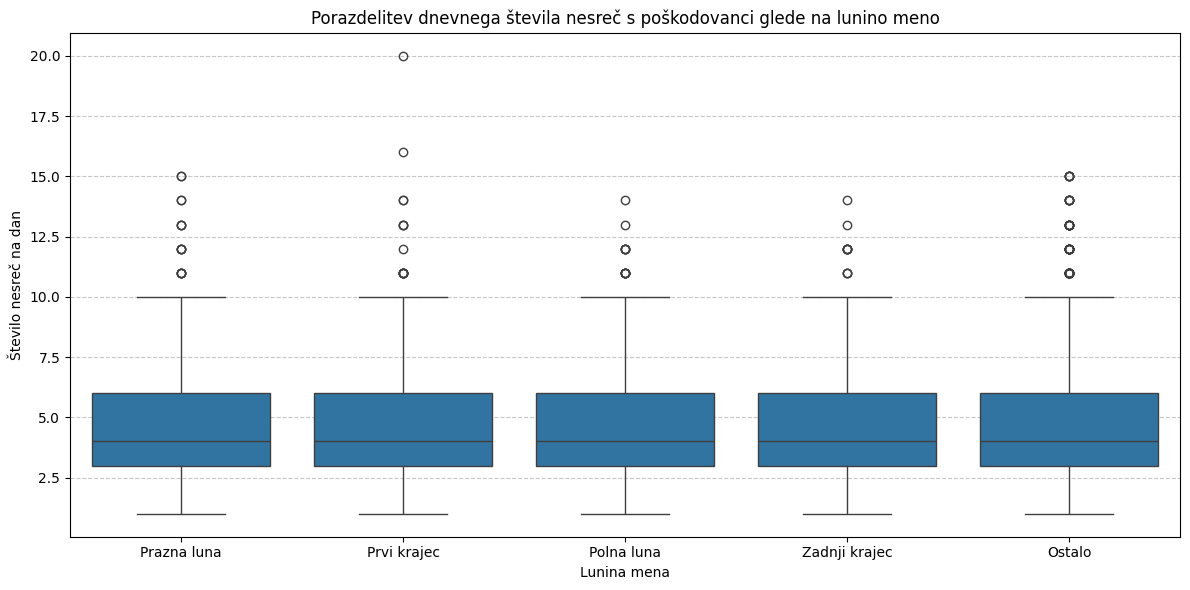

In [29]:
# BOXPLOT
mask_injury = (accidents_moon['Severity'] == 'injury')
df_injury = accidents_moon[mask_injury]

# Najprej grupiram in preštejem nesreče
grouped = df_injury.groupby(['Datum', 'moon_phase_SLO']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='moon_phase_SLO', y='accident_count', order=lunine_mene)
plt.title('Porazdelitev dnevnega števila nesreč s poškodovanci glede na lunino meno')
plt.xlabel('Lunina mena')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Nesreče s smrtnim izidom

moon_phase
New Moon         122
First Quarter    112
Full Moon        127
Last Quarter     133
None             731
Name: count, dtype: int64


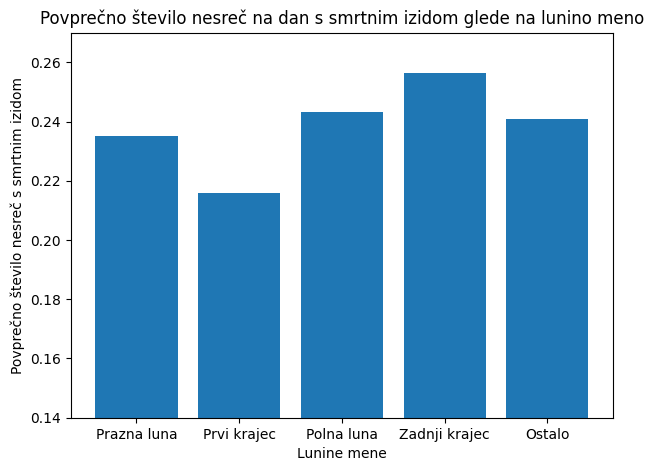

In [16]:
print(count_death)

# Stolpčni diagram za nepovprečene vrednosti
#
# plt.figure(figsize=(7, 5))
# plt.bar(lunine_mene[:-1], count_death.values)

# plt.xlabel('Lunine mene')
# plt.ylabel('Število nesreč s smrtnim izidom')
# plt.title('Število nesreč s smrtnim izidom glede na lunino meno')

# plt.ylim(60, 140)    # Y-os JE SKALIRANA!!
# plt.show()


# Povprečno število nesreč na dan brez poškodovancev glede na lunino meno
death_per_day = count_death / count_phase_days

# Stolpčni diagram
plt.figure(figsize=(7, 5))
plt.bar(lunine_mene, death_per_day.values)

plt.xlabel('Lunine mene')
plt.ylabel('Povprečno število nesreč s smrtnim izidom')
plt.title('Povprečno število nesreč na dan s smrtnim izidom glede na lunino meno')

plt.ylim(0.14, 0.27)    # Y-os JE SKALIRANA!!
plt.show()

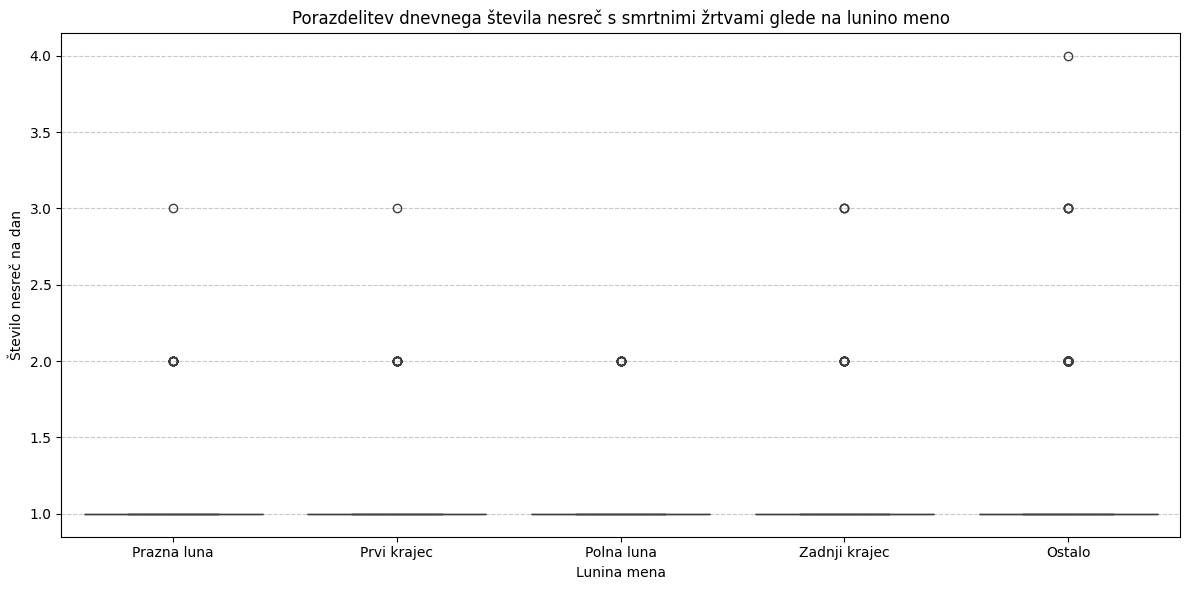

In [30]:
# BOXPLOT
mask_death = (accidents_moon['Severity'] == 'death')
df_death = accidents_moon[mask_death]

# Najprej grupiram in preštejem nesreče
grouped = df_death.groupby(['Datum', 'moon_phase_SLO']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='moon_phase_SLO', y='accident_count', order=lunine_mene)
plt.title('Porazdelitev dnevnega števila nesreč s smrtnimi žrtvami glede na lunino meno')
plt.xlabel('Lunina mena')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Prikaz normaliziranih vrednosti

X_norm = (X - X_min) / (X_max - X_min)

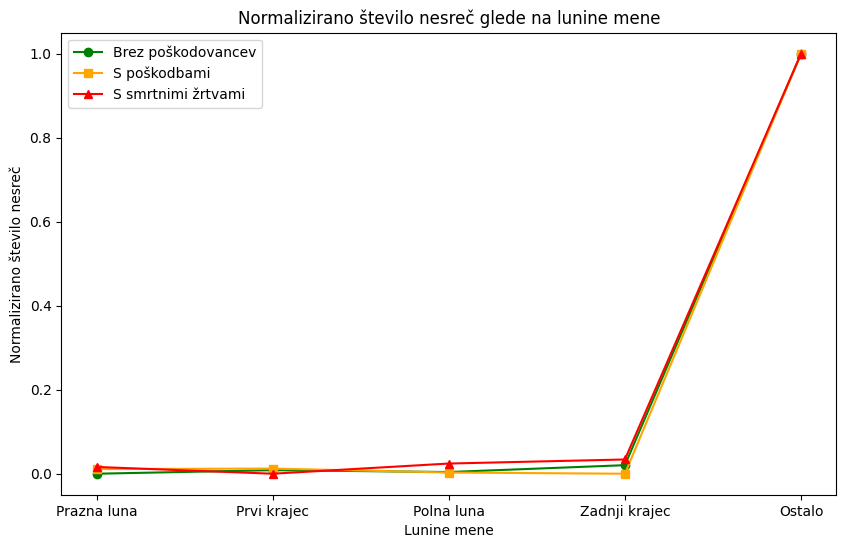

In [17]:
no_injury_norm = (count_no_injury.values - np.min(count_no_injury.values)) / (np.max(count_no_injury.values) - np.min(count_no_injury.values))
injury_norm = (count_injury.values - np.min(count_injury.values)) / (np.max(count_injury.values) - np.min(count_injury.values))
death_norm = (count_death.values - np.min(count_death.values)) / (np.max(count_death.values) - np.min(count_death.values))

plt.figure(figsize=(10, 6))

plt.plot(lunine_mene, no_injury_norm, marker='o', linestyle='-', label='Brez poškodovancev', color='green')
plt.plot(lunine_mene, injury_norm, marker='s', linestyle='-', label='S poškodbami', color='orange')
plt.plot(lunine_mene, death_norm, marker='^', linestyle='-', label='S smrtnimi žrtvami', color='red')

plt.xlabel('Lunine mene')
plt.ylabel('Normalizirano število nesreč')
plt.title('Normalizirano število nesreč glede na lunine mene')
plt.legend()

plt.show()


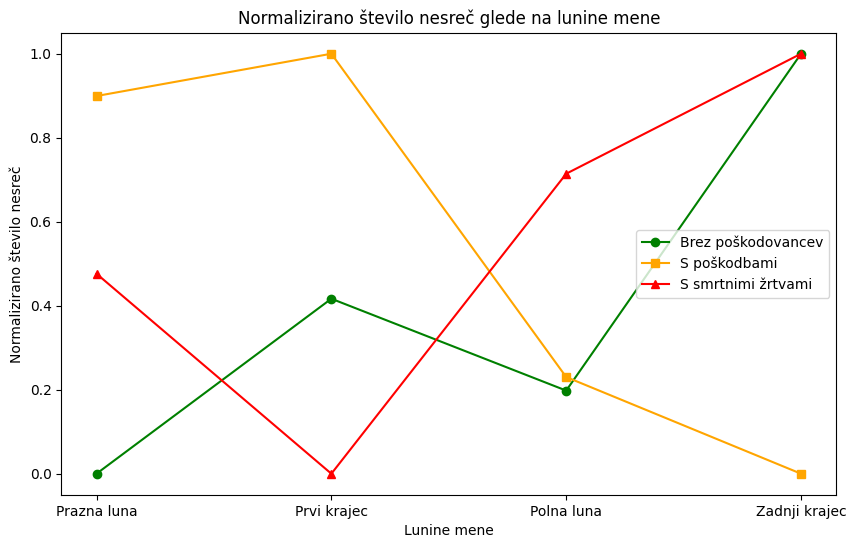

In [18]:
# Brez kategorije "Ostalo", da je malo bolj pregledno
count_no_injury = count_no_injury.drop('None')
count_injury = count_injury.drop('None')
count_death = count_death.drop('None')

no_injury_norm = (count_no_injury.values - np.min(count_no_injury.values)) / (np.max(count_no_injury.values) - np.min(count_no_injury.values))
injury_norm = (count_injury.values - np.min(count_injury.values)) / (np.max(count_injury.values) - np.min(count_injury.values))
death_norm = (count_death.values - np.min(count_death.values)) / (np.max(count_death.values) - np.min(count_death.values))

plt.figure(figsize=(10, 6))

plt.plot(lunine_mene[:-1], no_injury_norm, marker='o', linestyle='-', label='Brez poškodovancev', color='green')
plt.plot(lunine_mene[:-1], injury_norm, marker='s', linestyle='-', label='S poškodbami', color='orange')
plt.plot(lunine_mene[:-1], death_norm, marker='^', linestyle='-', label='S smrtnimi žrtvami', color='red')

plt.xlabel('Lunine mene')
plt.ylabel('Normalizirano število nesreč')
plt.title('Normalizirano število nesreč glede na lunine mene')
plt.legend()

plt.show()


### Boxplot

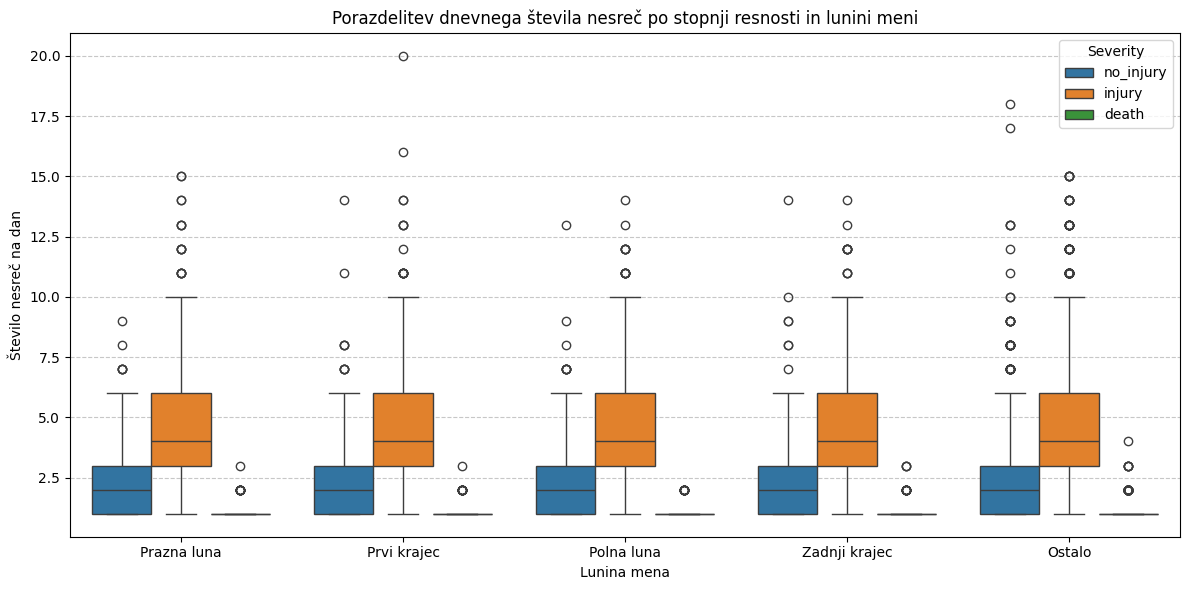

In [31]:
# Najprej grupiram in preštejem nesreče
grouped = accidents_moon.groupby(['Datum', 'moon_phase_SLO', 'Severity']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='moon_phase_SLO', y='accident_count', hue='Severity', order=lunine_mene)
plt.title('Porazdelitev dnevnega števila nesreč po stopnji resnosti in lunini meni')
plt.xlabel('Lunina mena')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Heatmap

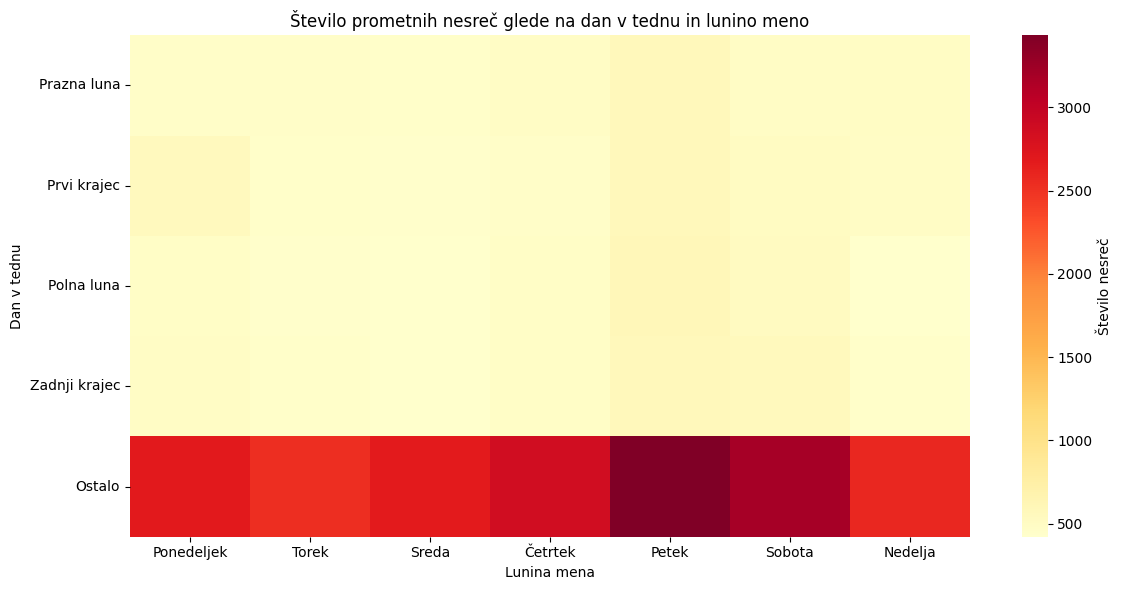

In [32]:
grouped = accidents_moon.groupby(['Day_SLO', 'moon_phase_SLO']).size()
grouped = grouped.reset_index(name='accident_count')

# Lunine mene in dneve razporedi po vrstnem redu
cat_type_moon = CategoricalDtype(categories=lunine_mene, ordered=True)
cat_type_day = CategoricalDtype(categories=day_order_slo, ordered=True)
grouped['moon_phase_SLO'] = grouped['moon_phase_SLO'].astype(cat_type_moon)
grouped['Day_SLO'] = grouped['Day_SLO'].astype(cat_type_day)
grouped = grouped.sort_values(['moon_phase_SLO', 'Day_SLO'])

df_heatmap = grouped.pivot(index='moon_phase_SLO', columns='Day_SLO', values='accident_count').fillna(0)
# display(df_heatmap)

# Heatmap
plt.figure(figsize=(12, 6))

sns.heatmap(df_heatmap, 
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Število nesreč'})
plt.xlabel('Lunina mena')
plt.ylabel('Dan v tednu')
plt.title('Število prometnih nesreč glede na dan v tednu in lunino meno')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

Še heatmap brez nesreč, ki so zgodile v dnevih, ko se ni menjala lunina mena.

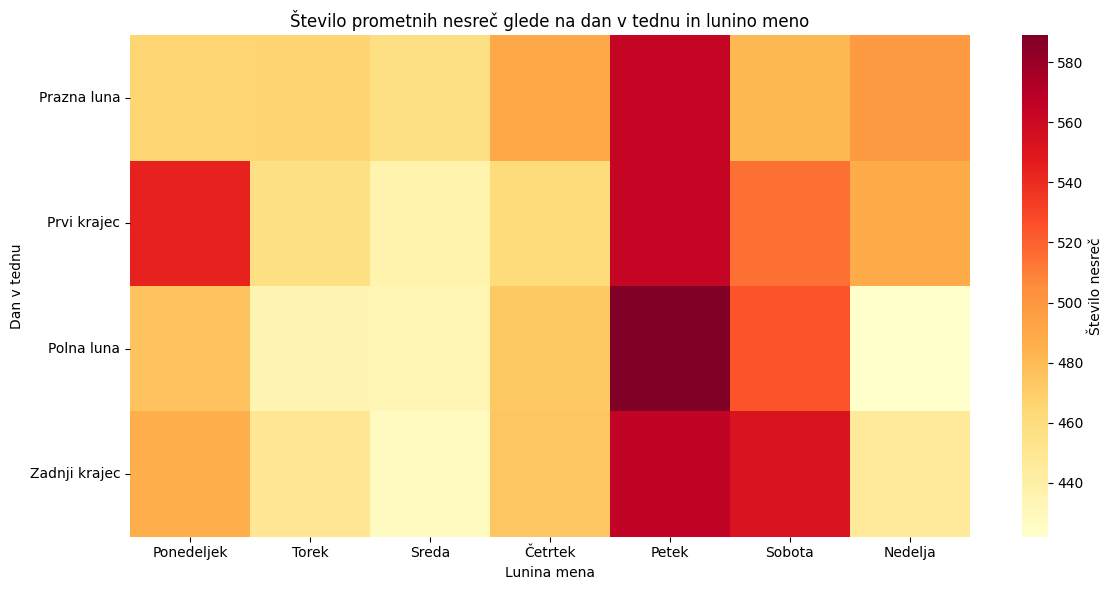

In [35]:
grouped = accidents_moon.groupby(['Day_SLO', 'moon_phase_SLO']).size()
grouped = grouped.reset_index(name='accident_count')

# Brez kategorije 'Ostalo'
grouped = grouped[grouped['moon_phase_SLO'] != 'Ostalo']

# Lunine mene in dneve razporedi po vrstnem redu
mene_filtered = [label for label in lunine_mene if label != 'Ostalo']
cat_type_moon = CategoricalDtype(categories=mene_filtered, ordered=True)
cat_type_day = CategoricalDtype(categories=day_order_slo, ordered=True)
grouped['moon_phase_SLO'] = grouped['moon_phase_SLO'].astype(cat_type_moon)
grouped['Day_SLO'] = grouped['Day_SLO'].astype(cat_type_day)
grouped = grouped.sort_values(['moon_phase_SLO', 'Day_SLO'])

df_heatmap = grouped.pivot(index='moon_phase_SLO', columns='Day_SLO', values='accident_count').fillna(0)
# display(df_heatmap)

# Heatmap
plt.figure(figsize=(12, 6))

sns.heatmap(df_heatmap, 
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Število nesreč'})
plt.xlabel('Lunina mena')
plt.ylabel('Dan v tednu')
plt.title('Število prometnih nesreč glede na dan v tednu in lunino meno')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

Glede na ure

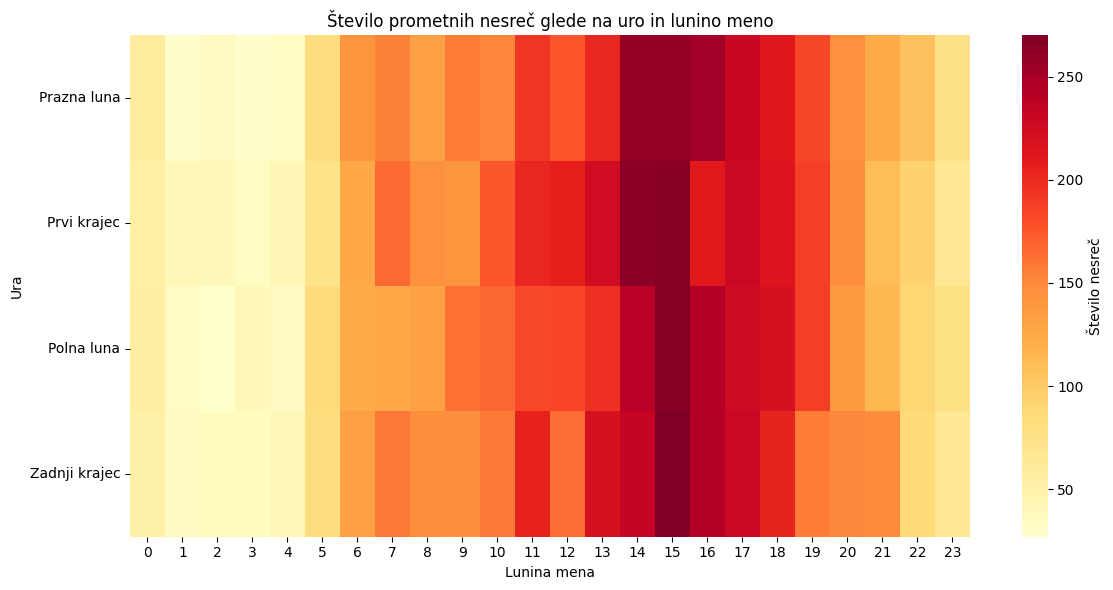

In [36]:
grouped = accidents_moon.groupby(['Ura', 'moon_phase_SLO']).size()
grouped = grouped.reset_index(name='accident_count')

# Brez kategorije 'Ostalo'
grouped = grouped[grouped['moon_phase_SLO'] != 'Ostalo']

# Lunine mene in dneve razporedi po vrstnem redu
mene_filtered = [label for label in lunine_mene if label != 'Ostalo']
cat_type_moon = CategoricalDtype(categories=mene_filtered, ordered=True)
grouped['moon_phase_SLO'] = grouped['moon_phase_SLO'].astype(cat_type_moon)
grouped = grouped.sort_values(['moon_phase_SLO'])

grouped['Ura'] = grouped['Ura'].astype(int)   # Da bodo ure smatrane kot številke in ne stringi. Da se bodo pravilno razporedile po x-osi.

df_heatmap = grouped.pivot(index='moon_phase_SLO', columns='Ura', values='accident_count').fillna(0)
# display(df_heatmap)

# Heatmap
plt.figure(figsize=(12, 6))

sns.heatmap(df_heatmap, 
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Število nesreč'})
plt.xlabel('Lunina mena')
plt.ylabel('Ura')
plt.title('Število prometnih nesreč glede na uro in lunino meno')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()